Preprocessing in Excel:
    1. Remove rows 1-3
    2. Remove average, min, max rows at end of file
    3. Export as csv

In [1]:
import pandas as pd
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# manually define building names
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']

# Consumption Data

In [3]:
# read from csv into a new dataframe
raw = pd.read_csv('energy_raw.csv',index_col=0,na_values=['#########'])

# reindex by appropriate datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# remove built-in demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# rename columns accordingly
raw.columns = buildingnames

In [4]:
# save the first five rows to replace later
raw_head = raw.head(5)
raw.describe()

,YUAG,Berkeley,Hopper,304Elm,Davenport,38HH,320Temple,53Wall,Sprague,Malone,Trumbull,17HH
count,4.991000e+03,4.991000e+03,4.991000e+03,4.991000e+03,4.991000e+03,4.991000e+03,4991.000000,4.991000e+03,4991.000000,4.991000e+03,4.991000e+03,4.991000e+03
mean,8.414169e+06,7.465573e+06,3.018159e+06,1.126277e+06,3.762755e+06,3.174013e+06,98637.747986,3.063754e+06,474177.614165,6.874799e+06,4.683953e+06,9.281003e+06
std,3.459993e+05,2.250370e+05,1.562374e+05,2.962100e+04,1.778626e+06,7.818495e+04,3551.134045,1.055216e+05,68154.385968,2.579452e+05,2.030521e+05,3.794849e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.179947e+06,7.357006e+06,2.904148e+06,1.117832e+06,4.347668e+06,3.169707e+06,96601.150000,3.047126e+06,416066.650000,6.710571e+06,4.563672e+06,9.111269e+06
50%,8.422790e+06,7.475622e+06,3.029166e+06,1.126659e+06,4.542060e+06,3.175551e+06,98763.800000,3.072880e+06,477017.800000,6.875171e+06,4.697258e+06,9.310198e+06
75%,8.660219e+06,7.583298e+06,3.145485e+06,1.135486e+06,4.715319e+06,3.181725e+06,100783.900000,3.097860e+06,533968.150000,7.047997e+06,4.817691e+06,9.500518e+06
max,8.892998e+06,7.692876e+06,3.229248e+06,1.149326e+06,4.869747e+06,3.190141e+06,103489.700000,3.122056e+06,583831.300000,7.221004e+06,4.933964e+06,9.681342e+06


In [5]:
# remove impossible outliers based on the percent change, limited by tau
# raw = raw.where(raw.pct_change(limit=1)>0)

# tau = 0.0005 * (raw.max()-raw.min())
# raw = raw.where(raw.pct_change(limit=1)<tau)

# replace consumption head before calculating demand
raw.iloc[[0,1,2,3,4],:] = raw_head

raw.isnull().sum()

YUAG         0
Berkeley     0
Hopper       0
304Elm       0
Davenport    0
38HH         0
320Temple    0
53Wall       0
Sprague      0
Malone       0
Trumbull     0
17HH         0
dtype: int64

In [6]:
# interpolates small ranges of missing consumption data (less than 6 hours)
# raw = raw.interpolate(method='time',limit=6,limit_area='inside')

# fn.plot_all(raw,'2018-06-14 00:00:00','2018-06-20 00:00:00')
raw.isnull().sum()

YUAG         0
Berkeley     0
Hopper       0
304Elm       0
Davenport    0
38HH         0
320Temple    0
53Wall       0
Sprague      0
Malone       0
Trumbull     0
17HH         0
dtype: int64

# Demand Data

YUAG         0
Berkeley     0
Hopper       0
304Elm       0
Davenport    0
38HH         0
320Temple    0
53Wall       0
Sprague      0
Malone       0
Trumbull     0
17HH         0
dtype: int64

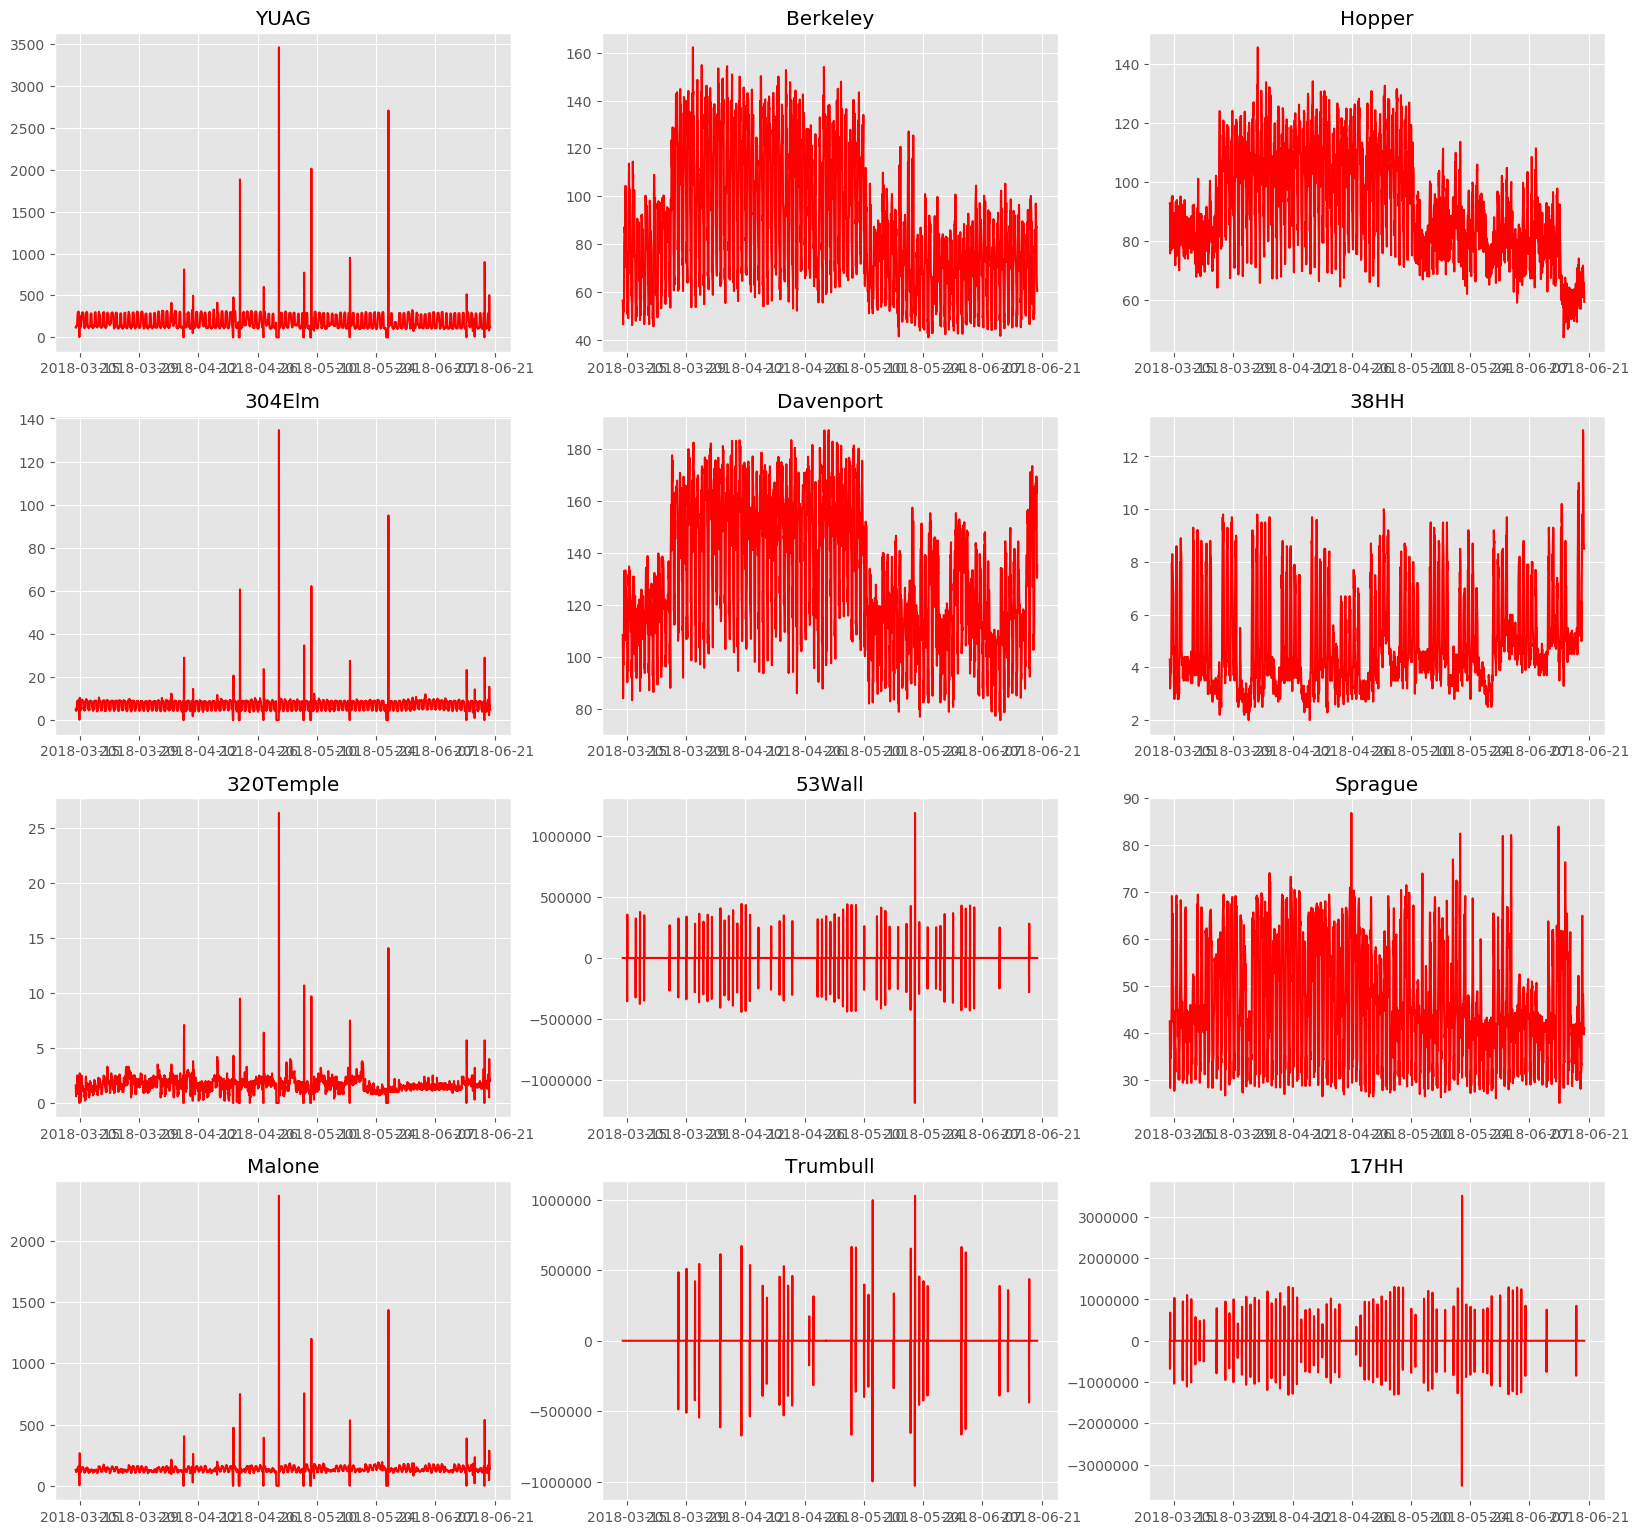

In [7]:
# creates a new dataframe for the demand values, drops the first row
demand = raw.diff().drop(raw.index[0])

# saves head to replace later
demand_head = demand.head(5)

fn.plot_all(demand,'2018-03-14 00:00:00','2018-06-20 00:00:00')
demand.isnull().sum()

In [8]:
# comp = demand.take([1], axis=1)
# comp['rolling'] = comp.loc[:,'Berkeley'].rolling(4,min_periods=1).median()
# # demand.rolling(4,min_periods=1).median()*0.5

# comp['rollmin'] = comp.loc[:,'Berkeley'].rolling(8,min_periods=6).min()

# # fn.plot_all(comp,'2018-03-14 00:00:00','2018-06-20 00:00:00')

# fn.plot_feature(comp,'rollmin','2018-01-02 00:00:00','2018-07-25 00:00:00')

# comp['rollmin'].median()-comp['rollmin'].std()

max_tuner = 1 # here i want higher values clipping more points
min_tuner = 1

# demand.std()/demand.median() # here high values indicate volatile, 

demand = demand.where(demand > demand.rolling(8,min_periods=4).min() - (min_tuner - demand.std()/demand.median()))
                      
demand = demand.where(demand < demand.rolling(8,min_periods=4).max() + (max_tuner - demand.std()/demand.median()))

fn.plot_all(demand,'2018-03-14 00:00:00','2018-06-20 00:00:00')


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1202eee18> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2000x6000 with 12 Axes>

In [9]:
# def rolling_clean(df,col)

#     for i in range(len(df)):
#         if df < df.rolling(5).median()*0.6:
#             slope = [(df[i+2]) - (df[i-1])]/3
#             df = [(df[i] + (df[i+1]))/2] - slope
#             df[i+1] = df[i] + 2*slope


demand = demand.where(demand > demand.rolling(2,min_periods=1).median()*0.6)

demand = demand.where(demand < demand.rolling(2).median()*1.5)

# another try, use larger window but the mean
# demand = demand.where(demand > demand.rolling(5).mean()*0.3).where(demand < demand.rolling(5).mean()*2)

fn.plot_all(demand,'2018-03-14 00:00:00','2018-06-20 00:00:00')
demand.isnull().sum()

YUAG         4984
Berkeley     4984
Hopper       4984
304Elm       4984
Davenport    4984
38HH         4984
320Temple    4984
53Wall       4677
Sprague      4981
Malone       4984
Trumbull     4798
17HH         4556
dtype: int64

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1202eee18> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2000x6000 with 12 Axes>

In [10]:
# interpolate, leaving 74 missing??? check locations.
demand = demand.interpolate(method='time',limit=6)

fn.plot_all(demand,'2018-06-14 00:00:00','2018-06-20 00:00:00')
demand.isnull().sum()

YUAG         4972
Berkeley     4972
Hopper       4972
304Elm       4972
Davenport    4972
38HH         4972
320Temple    4972
53Wall       4047
Sprague      4963
Malone       4972
Trumbull     4408
17HH         3680
dtype: int64

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1202eee18> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2000x6000 with 12 Axes>

In [11]:
nan_index = demand['YUAG'].index[demand['YUAG'].apply(np.isnan)]
print(nan_index)

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2018-07-27 14:00:00', '2018-07-27 15:00:00',
               '2018-07-27 16:00:00', '2018-07-27 17:00:00',
               '2018-07-27 18:00:00', '2018-07-27 19:00:00',
               '2018-07-27 20:00:00', '2018-07-27 21:00:00',
               '2018-07-27 22:00:00', '2018-07-27 23:00:00'],
              dtype='datetime64[ns]', length=4972, freq=None)


In [12]:
fn.plot_all(demand,'2018-06-01 00:00:00','2018-07-01 00:00:00')
demand.isnull().sum()

YUAG         4972
Berkeley     4972
Hopper       4972
304Elm       4972
Davenport    4972
38HH         4972
320Temple    4972
53Wall       4047
Sprague      4963
Malone       4972
Trumbull     4408
17HH         3680
dtype: int64

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1202eee18> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2000x6000 with 12 Axes>

In [13]:
demand.describe()

,YUAG,Berkeley,Hopper,304Elm,Davenport,38HH,320Temple,53Wall,Sprague,Malone,Trumbull,17HH
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,943.000000,27.000000,18.000000,582.000000,1310.000000
mean,162.301757,101.136460,100.341447,8.398217,150.357054,4.623850,2.140103,16.872918,37.226441,122.784961,91.890346,138.089533
std,21.095492,23.652413,11.056218,1.311806,11.493802,0.731428,0.463788,2.069567,11.103389,8.123529,15.668978,11.812521
min,123.900000,59.700000,85.300000,4.900000,118.900000,3.900000,1.000000,9.800000,25.600000,114.200000,59.700000,78.500000
25%,152.881279,90.060349,93.042558,8.909070,151.753721,4.003140,2.178605,15.300352,26.700000,116.203140,80.123864,131.659536
50%,152.895116,90.453721,93.093953,8.976279,152.153023,4.154186,2.194419,16.569565,34.242791,116.354186,91.548958,137.200000
75%,186.000000,126.900000,113.300000,9.000000,158.500000,5.500000,2.500000,18.016618,46.666370,132.500000,102.898319,144.931818
max,186.000000,126.900000,113.300000,9.000000,158.500000,5.500000,2.500000,29.500000,54.600000,132.500000,149.500000,241.300000


In [14]:
# final interpolation of demand values after dropping outliers
# this needs to be replaced with FFT for any gaps longer than ~6 hours
demand = demand.interpolate(method='time',limit=24)

print(demand.isnull().sum())

# returns index labels where nan values appear for a certain column
nan_index = demand['304Elm'].index[demand['304Elm'].apply(np.isnan)]
print(nan_index)

YUAG         4924
Berkeley     4924
Hopper       4924
304Elm       4924
Davenport    4924
38HH         4924
320Temple    4924
53Wall       2127
Sprague      4891
Malone       4924
Trumbull     3064
17HH         1189
dtype: int64
DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2018-07-27 14:00:00', '2018-07-27 15:00:00',
               '2018-07-27 16:00:00', '2018-07-27 17:00:00',
               '2018-07-27 18:00:00', '2018-07-27 19:00:00',
               '2018-07-27 20:00:00', '2018-07-27 21:00:00',
               '2018-07-27 22:00:00', '2018-07-27 23:00:00'],
              dtype='datetime64[ns]', length=4924, freq=None)


In [15]:
# replace head for final export
demand.iloc[[0,1,2,3,4],:] = demand_head

# final = demand.copy(deep=True).round(1)

final.to_csv('energy_clean.csv')

NameError: name 'final' is not defined

# unused code below

In [ ]:
# # this cell removes all consumption values BELOW first value

# # creates dataframe of repeated minimum (first) values, pretty workaroundy
# raw_mins = raw.copy(deep=True)
# raw_mins.loc[:,:] = raw.loc['2018-01-01 00:00:00'].values

# # sets all violating values to NaN
# raw = raw.where(raw >= raw_mins)

# # this unused line was an attempt to find outliers using std ranges
# # raw = raw.where(raw > raw.median() - 2*raw.std()).where(raw < raw.median() + 2*raw.std())

# raw.isnull().sum()

In [ ]:
# trying to plot daily average curves for buildings... matplotlib might support this somehow or i can write a fn

# raw = raw.iloc[:,[0]]

# raw['day'] = raw.index.day
# raw['hour'] = raw.index.hour

# raw_by_day = raw.resample('h').mean()
# raw_by_day = raw_by_day.set_index(['day','hour']).unstack('day')
# raw_by_day

In [ ]:
# this was an attempt to find sensor error outliers using quantiles, std, medians, etc. BEFORE I discovered .rolling
# lower=1
# upper=3

# demand = demand.where(demand > demand.quantile(q=0.1)-(lower*demand.std()))

# demand = demand.where(demand > demand.median()-(lower*demand.std()))

# demand = demand.where(demand < demand.median()+(upper*demand.std()))


# removes strong statistical outliers

# demand = demand.where(demand > demand.median()/2).where(demand < demand.median()*2)